# Small World Graphs

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 3

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [2]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [3]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [4]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [5]:
nodes = range(4)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 3)
(3, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [6]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [7]:
lattice = make_ring_lattice(10, 6)

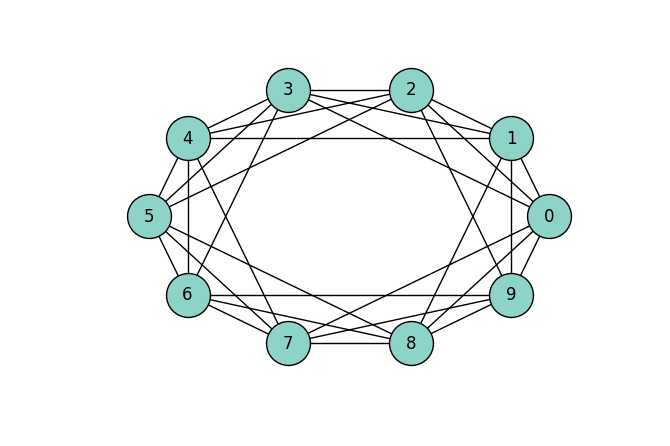

In [8]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)
plt.savefig('chap03-1.pdf')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=2` or `k=5`.

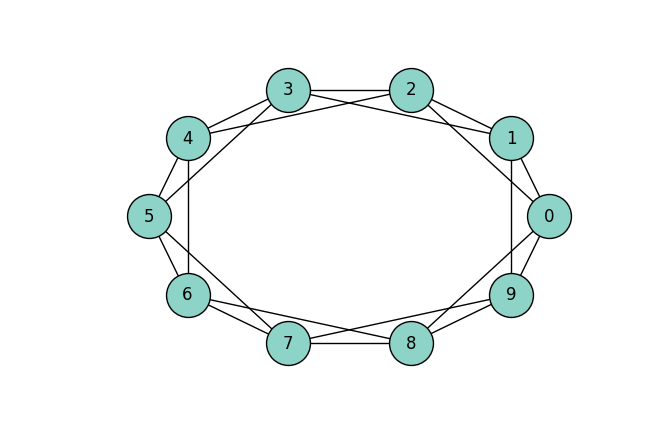

In [36]:
lattice_odd = make_ring_lattice(10, 5)
nx.draw_circular(lattice_odd, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)

## WS graph

To make a WS, you start with a ring lattice and then rewire.

In [10]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

In [11]:
print(lattice[3])

{0: {}, 1: {}, 2: {}, 4: {}, 5: {}, 6: {}}


Here's the function that does the rewiring

In [12]:
from numpy.random import choice

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G.nodes())
    for edge in G.edges():
        if flip(p):
            u, v = edge
            choices = nodes - {u} - set(G[u])
            new_v = choice(tuple(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

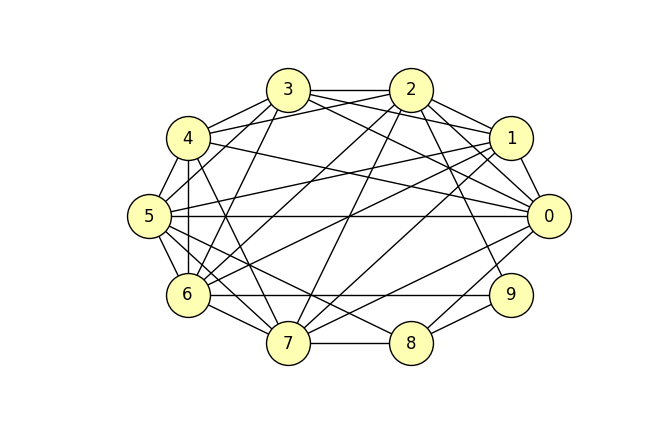

In [13]:
ws = make_ws_graph(10, 6, 0.2)
nx.draw_circular(ws, 
                 node_color=COLORS[1], 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [14]:
len(lattice.edges()), len(ws.edges())

(30, 30)

Now I'll generate a plot that shows WS graphs for a few values of `p`

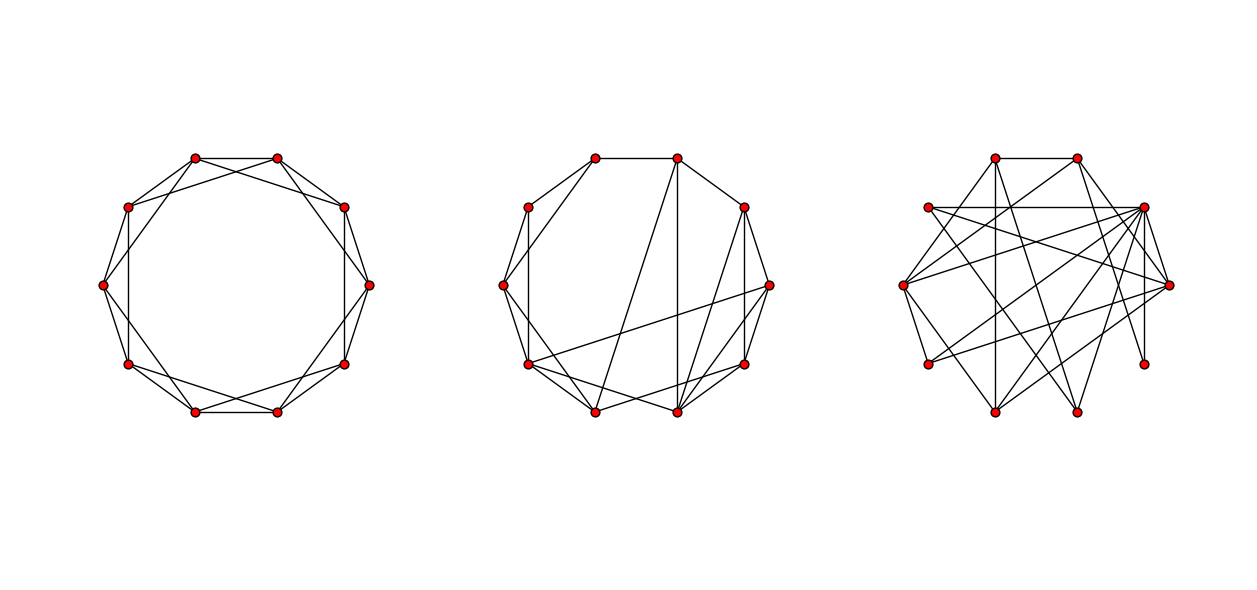

In [15]:
n = 10
k = 4
ns = 40

thinkplot.preplot(cols=3)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
plt.savefig('chap03-2.pdf')

**Exercise:** What is the order of growth of `rewire`?

I think it would be O(kn), or the number of edges, since it loops through every edge and checks?

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [16]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / total

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [17]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cc = np.mean([node_clustering(G, node) for node in G])
    return cc

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [18]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [19]:
clustering_coefficient(lattice)

0.5

Correct.

**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.

In [20]:
def node_clustering2(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = [(v,w) for v,w in all_pairs(neighbors) if G.has_edge(v,w)]
    return len(exist) / total

def clustering_coefficient2(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cc = np.mean([node_clustering2(G, node) for node in G])
    return cc

print(node_clustering2(lattice, 1), clustering_coefficient2(lattice))

0.5 0.5


**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

So all_pairs is (I think) O(k^2) as k represents the number of neighbors for each node. node_clustering is fairly constant time, as the main thing it does is call all_pairs and then check the output, so is dependent on the result of all_pairs; I'd estimate around another k, so that part is maybe O(k+k^2). We then execute this for every node, n, so the overall length of clustering_coefficient is O(n(k+k^2)).

## Path length

The following function computes path lengths between all pairs of nodes

In [21]:
def path_lengths(G):
    length_map = nx.shortest_path_length(G)
    lengths = [length_map[u][v] for u, v in all_pairs(G)]
    return lengths

The characteristic path length is the mean path length for all pairs.

In [22]:
def characteristic_path_length(G):
    return np.mean(path_lengths(G))

On a complete graph, the average path length should be 1

In [23]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

1.0

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [24]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [25]:
lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.6666666666666667

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [26]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes about a second on my computer:

In [27]:
%time run_one_graph(1000, 10, 0.01)

8.22071671672 0.643439033189
CPU times: user 1.9 s, sys: 24 ms, total: 1.92 s
Wall time: 1.93 s


(8.2207167167167174, 0.64343903318903317)

Now we'll run it with a range of values for `p`.

In [28]:
ps = np.logspace(-4, 0, 9)
print(ps)

[  1.00000000e-04   3.16227766e-04   1.00000000e-03   3.16227766e-03
   1.00000000e-02   3.16227766e-02   1.00000000e-01   3.16227766e-01
   1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [37]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns: sequence of (mpl, cc) pairs
    """
    res = {}
    for p in ps:
        print(p)
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_graph(n, k, p))
    return res

Here are the raw results

In [38]:
res = run_experiment(ps)

0.0001
50.4504504505 0.666666666667
45.0688648649 0.666206565657
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
43.3231951952 0.666206565657
41.4201041041 0.666206565657
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
49.9697917918 0.666206565657
50.4504504505 0.666666666667
44.6417677678 0.666134343434
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
38.5295295295 0.665963131313
50.4504504505 0.666666666667
50.4504504505 0.666666666667
0.000316227766017
43.605955956 0.666206565657
46.3148668669 0.666351010101
34.9326126126 0.665890909091
38.4675175175 0.666278787879
50.4504504505 0.666666666667
42.9583283283 0.666134343434
38.465041041 0.666134343434
39.0990930931 0.666278787879
37.7644704705 0.665674242424
25.5813593594 0.66571969697
47.4102542543 0.665674242424
47.2872592593 0.666351010101
48.0983343343 0.666351010101
27.0531271271 0.66586

Now we have to extract them in a form we can plot

In [39]:
L = []
C = []
for p, t in sorted(res.items()):
    mpls, ccs = zip(*t)
    mpl = np.mean(mpls)
    cc = np.mean(ccs)
    L.append(mpl)
    C.append(cc)
    
print(L)
print(C)

[48.462977977977985, 40.341050950950951, 28.060061961961964, 15.31225175175175, 9.0013987987987996, 5.9264661661661666, 4.4387923923923918, 3.5813481481481491, 3.2678799799799796]
[0.66651285353535328, 0.66609340909090897, 0.66475181818181805, 0.66043553751803752, 0.64774940836940842, 0.60646752497502487, 0.49128589743589746, 0.2211753655739685, 0.0090198485325304195]


And normalize them so they both start at 1.0

In [40]:
L = np.array(L) / L[0]
C = np.array(C) / C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

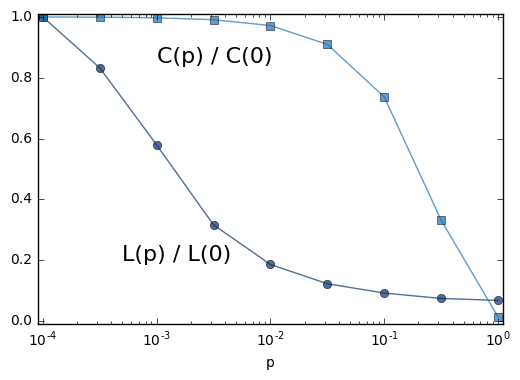

In [41]:
thinkplot.plot(ps, L, style='o-', linewidth=1)
thinkplot.plot(ps, C, style='s-', linewidth=1)
thinkplot.text(0.001, 0.9, 'C(p) / C(0)')
thinkplot.text(0.0005, 0.25, 'L(p) / L(0)')
thinkplot.config(xlabel='p', xscale='log',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])
plt.savefig('chap03-3.pdf')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [ ]:
lattice = make_ring_lattice(10, 4)

In [ ]:
nx.draw_circular(lattice, 
                 node_color=COLORS[2], 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [ ]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [ ]:
reachable_nodes_bfs(lattice, 0)

Here's a version that's a little faster, but maybe less readable.

In [ ]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) 
            neighbors -= seen
            queue.extend(neighbors)
    return seen

It works, too.

In [ ]:
reachable_nodes_bfs(lattice, 0)

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [ ]:
def shortest_path_dijkstra(G, start):
    """Finds shortest paths from `start` to all other nodes.
    
    G: graph
    start: node to start at
    
    returns: make from node to path length
    """
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [ ]:
lattice = make_ring_lattice(10, 4)

In [ ]:
nx.draw_circular(lattice, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [ ]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

And here's the result from NetworkX:

In [ ]:
d2 = nx.shortest_path_length(lattice, 0)
d2

They are the same:

In [ ]:
d1 == d2

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [ ]:
# To get the furthest node, find the halfway (rounding up): 
#  1000/2 = 500
# Each time, the path can take a step of up to 5 (k/2) towards
#  this value, so: 
#  500/5 = 100 steps

largeLattice = make_ring_lattice(1000, 10)
d = shortest_path_dijkstra(largeLattice, 0)
#max(d.values())
print([(key,val) for key,val in d.items() if val >= 100])
#print("Maximum distance:", max(d.values()), "\n499:",d[499], "500:",d[500], "501:", d[501])

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [ ]:
import random

def make_regular_graph_obsolete(n, k):
    """ Produces a regular graph for a given
    n and k value.
    n: number of nodes
    k: number of neighbors per node.
    """
    if k >= n:
        raise ValueError
    G = nx.Graph()
    G.add_nodes_from(range(n))
    enough_edges = set()
    for node in G.node:
        edges_needed = k - len(G[node])
        targets = random.sample(set(G.node) - enough_edges - {node}, edges_needed)
        G.add_edges_from([(node, n2) for n2 in targets])
        hasEnough = [n for n in targets if len(G[n])==k]
        enough_edges.add(node)
        enough_edges.update(hasEnough)
    
    return G

# Ended up looking at the solution thinking that we were trying to construct random but regular graphs and
#  wanting to seen how Allen dealt with certain issues I was running into.
    
def make_regular_graph(n, k):
    """ Produces a regular graph for a given
    n and k value.
    n: number of nodes
    k: number of neighbors per node.
    """
    adj, odd = divmod(k,2)
    
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(adjacent_edges(range(n),adj))
    if odd:
        if n%2:
            raise ValueError("Cannot construct a regular graph if both n and k are odd")
        for node in G.node:
            G.add_edge(node, (node+n//2)%n)
    return G

In [ ]:
G = nx.Graph()
G.add_nodes_from(range(5))

In [ ]:
G1 = make_regular_graph(10,3)
nx.draw_circular(G1, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

In [ ]:
G1[3]

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [ ]:
def plain_bfs(G, source):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [ ]:
%timeit len(plain_bfs(largeLattice, 0))

In [ ]:
%timeit len(reachable_nodes_bfs(largeLattice, 0))

Definitely plain_bfs

In [ ]:
def shortest_path_dijkstra2(G, start):
    """Finds shortest paths from `start` to all other nodes.
    
    G: graph
    start: node to start at
    
    returns: make from node to path length
    """
    distDict = {}
    dist = 0
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in distDict:
                distDict[v] = dist
                nextlevel.update(G[v])
        dist+=1
    return distDict

In [ ]:
largeLattice = make_ring_lattice(1000, 10)
d = shortest_path_dijkstra2(largeLattice, 0)
d2 = shortest_path_dijkstra(largeLattice, 0)


In [ ]:
%timeit len(shortest_path_dijkstra2(largeLattice, 0))

In [ ]:
%timeit len(shortest_path_dijkstra(largeLattice, 0))

In [ ]:
# Solution goes here

**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [ ]:
def bfs(top_node, visit):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [top_node]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue <<<< Should not have pop(0), should use deque and popleft instead
        visit(curr_node)            # Visit the node
        visited.add(curr_node)      # <<<< uses both visited and queue? queue is a list, so longer to search than visited

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in curr_node.children
                     if c not in visited and c not in queue) # <<<< should check if c is in visited. But also, this could run for so very long that it's just a really bad idea to check it here.

In [ ]:
# Solution goes here

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

So the thing here is that it's going to dive down the wrong trail and find the number. "Oh look," it says, "I found the thing!" However it is wrong, because maybe if it had tried another 'door' first, it would have found it sooner. You could maybe check every time if it has been found before, and make the shortest distance the current value, but... that's just really inefficient. EDIT: ...nah, seems like the check didn't work either. Interesting.

In [ ]:
def shortest_path_dfs(G, start):
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.pop()
        new_dist = dist[node] + 1

        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            if n not in dist or new_dist > dist[n]:
                dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

#Sure enough, it gets the answers wrong

lattice = make_ring_lattice(10, 4)
d1 = shortest_path_dfs(lattice, 0)
print(d1)
d2 = nx.shortest_path_length(lattice, 0)
print(d2)
d1 == d2